In [1]:
import pandas as pd
import sqlite3

## make a connection to the database

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

## analyze only the users and not the admins

In [3]:
query = '''
SELECT *
FROM checker
WHERE uid LIKE 'user_%'
'''
checker = pd.io.sql.read_sql(query, conn)
checker

,index,status,success,timestamp,numTrials,labname,uid
0,7,ready,0,2020-04-17 05:19:02.744528,1,project1,user_4
1,8,checking,0,2020-04-17 05:22:35.249331,2,project1,user_4
2,9,ready,1,2020-04-17 05:22:45.549397,2,project1,user_4
3,10,checking,1,2020-04-17 05:34:14.691200,3,project1,user_4
4,11,ready,1,2020-04-17 05:34:24.422370,3,project1,user_4
...,...,...,...,...,...,...,...
3202,3397,ready,0,2020-05-21 20:19:06.872761,7,laba06s,user_1
3203,3398,checking,0,2020-05-21 20:22:41.785725,8,laba06s,user_1
3204,3399,ready,0,2020-05-21 20:22:41.877806,8,laba06s,user_1
3205,3400,checking,0,2020-05-21 20:37:00.129678,9,laba06s,user_1


In [4]:
checker_new =  pd.DataFrame((pd.to_datetime(checker['timestamp'])).copy())
checker_new.columns=['datetime']
checker_new['uid']=checker['uid'].copy()
checker_new

,datetime,uid
0,2020-04-17 05:19:02.744528,user_4
1,2020-04-17 05:22:35.249331,user_4
2,2020-04-17 05:22:45.549397,user_4
3,2020-04-17 05:34:14.691200,user_4
4,2020-04-17 05:34:24.422370,user_4
...,...,...
3202,2020-05-21 20:19:06.872761,user_1
3203,2020-05-21 20:22:41.785725,user_1
3204,2020-05-21 20:22:41.877806,user_1
3205,2020-05-21 20:37:00.129678,user_1


In [5]:
checker_new['hour'] = (pd.to_datetime(checker['timestamp'])).dt.hour
checker_new['date'] = checker_new['datetime'].dt.date
checker_new.drop('datetime', axis=1, inplace=True)
checker_new

,uid,hour,date
0,user_4,5,2020-04-17
1,user_4,5,2020-04-17
2,user_4,5,2020-04-17
3,user_4,5,2020-04-17
4,user_4,5,2020-04-17
...,...,...,...
3202,user_1,20,2020-05-21
3203,user_1,20,2020-05-21
3204,user_1,20,2020-05-21
3205,user_1,20,2020-05-21


In [6]:
checker_new['day_of_week'] = (pd.to_datetime(checker_new['date'])).dt.day_name()
checker_new

,uid,hour,date,day_of_week
0,user_4,5,2020-04-17,Friday
1,user_4,5,2020-04-17,Friday
2,user_4,5,2020-04-17,Friday
3,user_4,5,2020-04-17,Friday
4,user_4,5,2020-04-17,Friday
...,...,...,...,...
3202,user_1,20,2020-05-21,Thursday
3203,user_1,20,2020-05-21,Thursday
3204,user_1,20,2020-05-21,Thursday
3205,user_1,20,2020-05-21,Thursday


In [7]:
working_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']
checker_new['working_days'] = checker_new['day_of_week'].isin(working_days)
checker_new['weekends'] = checker_new['day_of_week'].isin(weekends)
checker_new

,uid,hour,date,day_of_week,working_days,weekends
0,user_4,5,2020-04-17,Friday,True,False
1,user_4,5,2020-04-17,Friday,True,False
2,user_4,5,2020-04-17,Friday,True,False
3,user_4,5,2020-04-17,Friday,True,False
4,user_4,5,2020-04-17,Friday,True,False
...,...,...,...,...,...,...
3202,user_1,20,2020-05-21,Thursday,True,False
3203,user_1,20,2020-05-21,Thursday,True,False
3204,user_1,20,2020-05-21,Thursday,True,False
3205,user_1,20,2020-05-21,Thursday,True,False


## for each hour, calculate the average number of commits on working days and on weekends

In [8]:
checker_new['kind_of_the_day']= checker_new['working_days'].apply(lambda x: 'Working Day' if x else 'Weekend')
commits_sum = checker_new.groupby(['day_of_week', 'kind_of_the_day', 'date', 'hour']).size().reset_index(name='commits_count')
commits_sum

,day_of_week,kind_of_the_day,date,hour,commits_count
0,Friday,Working Day,2020-04-17,5,13
1,Friday,Working Day,2020-04-17,11,8
2,Friday,Working Day,2020-04-17,12,2
3,Friday,Working Day,2020-04-24,10,2
4,Friday,Working Day,2020-04-24,16,2
...,...,...,...,...,...
283,Wednesday,Working Day,2020-05-20,15,2
284,Wednesday,Working Day,2020-05-20,20,1
285,Wednesday,Working Day,2020-05-20,21,2
286,Wednesday,Working Day,2020-05-20,22,4


In [9]:
average_commits = commits_sum[commits_sum['commits_count'] > 0].groupby(['hour', 'kind_of_the_day'])['commits_count'].mean().reset_index()
average_commits_pivot = average_commits.pivot(index='hour', columns='kind_of_the_day', values='commits_count')
average_commits_pivot = average_commits_pivot.reindex(pd.Index(range(24), name = 'hour'))
print(average_commits_pivot)

kind_of_the_day    Weekend  Working Day
hour                                   
0                 2.000000     3.000000
1                 6.000000          NaN
2                      NaN          NaN
3                 1.000000     2.000000
4                      NaN          NaN
5                 2.000000     7.500000
6                      NaN     1.500000
7                 4.000000     5.166667
8                 7.000000     3.700000
9                 3.666667     6.000000
10                7.000000    13.200000
11               23.600000     6.769231
12                9.500000     7.181818
13               18.000000     8.111111
14               12.428571    10.166667
15               14.250000    12.818182
16               14.800000    18.888889
17                7.142857    16.000000
18                9.714286    15.181818
19               13.125000    17.833333
20               13.000000    14.076923
21               10.285714    24.333333
22                9.833333     3.750000


array([<Axes: title={'center': 'Weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'Working Day'}, xlabel='hour'>],
      dtype=object)

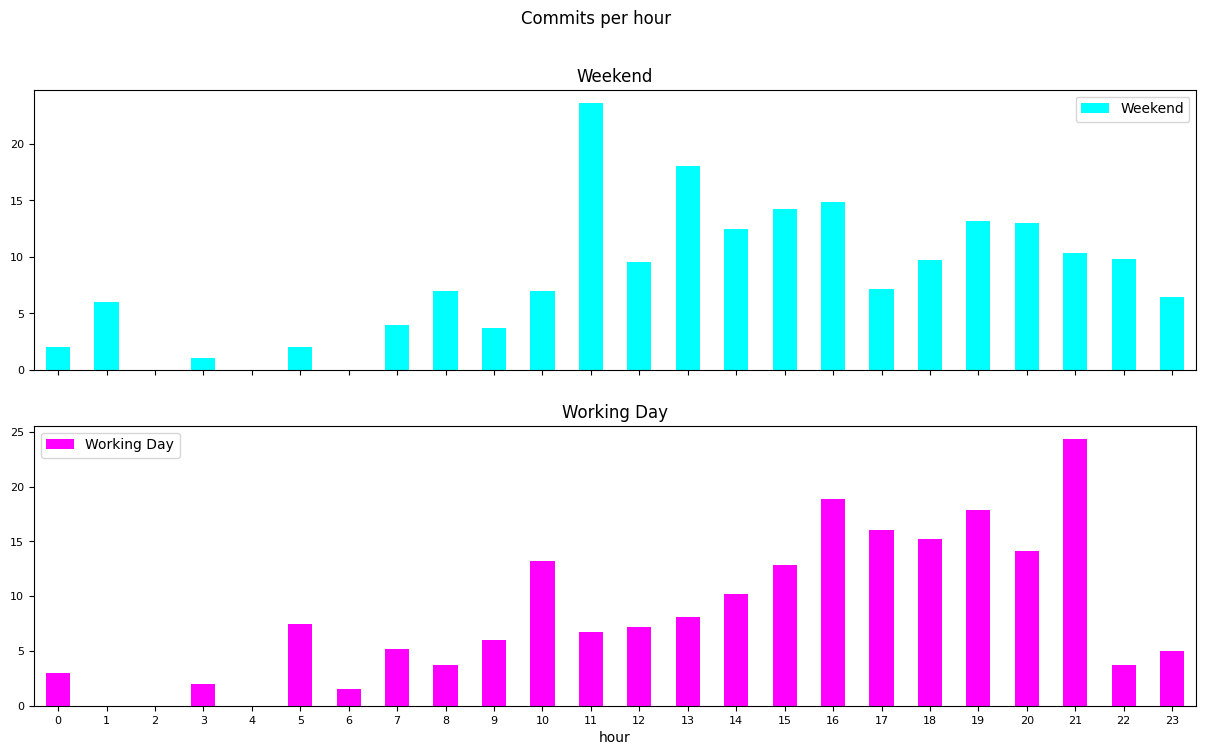

In [10]:
average_commits_pivot.plot(kind='bar',
                      figsize=(15, 8),
                      title='Commits per hour',
                      rot=0,
                      fontsize=8,
                      colormap='cool',
                      subplots=True)

## “Is the dynamic different on working days and weekends?”

##  the number of commits is the largest during working days: 21

In [11]:
average_commits_pivot[average_commits_pivot['Working Day'] == average_commits_pivot['Working Day'].max()]

kind_of_the_day,Weekend,Working Day
hour,,
21,10.285714,24.333333


## the number of commits is the largest during weekend: 11

In [12]:
average_commits_pivot[average_commits_pivot['Weekend'] == average_commits_pivot['Weekend'].max()]

kind_of_the_day,Weekend,Working Day
hour,,
11,23.6,6.769231


## close the connection

In [13]:
conn.close()